# Simulation of Inventory and Sales

Data
- Items and Inventory in May 2024
- Demand from September 2021 to May 2024

In [167]:
include("src/utils.jl")
include("src/read_data.jl")
include("src/plot_data.jl")
include("src/forecast.jl")

add_ma_forecast! (generic function with 3 methods)

**Read the data sets**
- *items* : dataframe with all items and their inventory positions
- *demand* : dataframe with monthly demands 

In [119]:
items,demand = read_items(), read_demand()
abc_categories = levels(items[!,:ABC])
@show size(items)
pretty(items[1:5,:])

size(items) = (25918, 19)


ITEM,DESCRIPTION,DEFAULT_SUPPLYSOURCE,PRODUCTGROUP,PROD.CLASS,BUY_FROMBP,IMLO,<12_MONTHS,12-24_MONTHS,SIGNAL,ABC,EXTRAINF,WHSE,INV_ONHAND,INV_ONORDER,INVALLOCATED,SALESCONTRACT,ALTERNATIVEITEM,VALUE
10C-E1102-00,CYLINDER HEAD ASSY 10C3-1,Purchase,ZSEN10,IM10C,01YAIA,IM,0.00,24.00,TMP,D,missing,SPHQ,1.00,10.00,0.00,0.00,missing,88.04
10C-E1111-10,"HEAD, CYLINDER 1",Purchase,ZSEN10,LO10C,01HIYA,LO,0.00,0.00,TMP,E,missing,SPHQ,0.00,0.00,0.00,0.00,missing,77.63
10C-E1181-00,"GASKET, CYLINDER HE (10C4)",Purchase,ZSEN10,LO10C,01HIYA,LO,0.00,0.00,SO,E,missing,SPHQ,23.00,0.00,1.00,0.00,missing,3.61
10C-E1351-00,"GASKET, CYLINDER (10C4)",Purchase,ZSEN10,LO10C,01HIYA,LO,0.00,0.00,SO,E,missing,SPHQ,21.00,0.00,22.00,0.00,missing,0.15
10C-E1633-00,"PIN, PISTON (10C4)",Purchase,ZSEN10,LO10C,01HIYA,LO,0.00,0.00,TMP,E,missing,SPHQ,9.00,0.00,9.00,0.00,missing,2.05


## Analysis of Demand

length(months) = 33
money(last_12m_sales) = "RM 63,398,607"


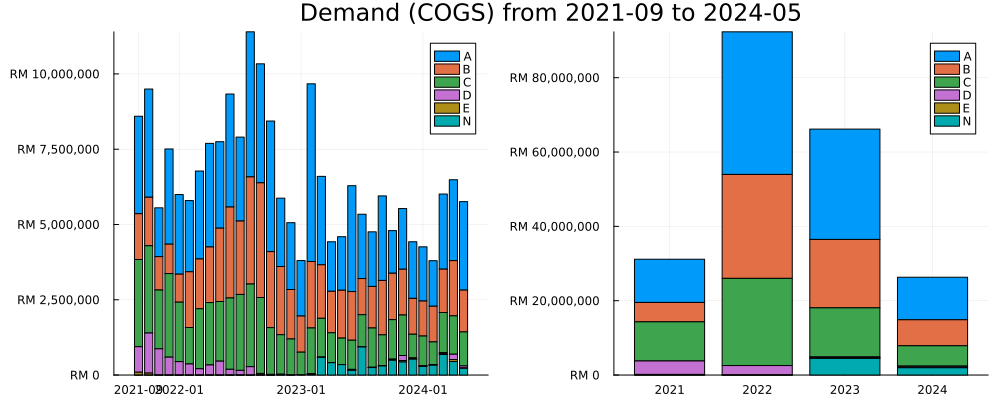

In [19]:
# collect the months
months = unique(demand[!,:MONTH]); sort!(months)
@show length(months)

# aggregate demand value by month and ABC category, and use the index for the month
dmc = innerjoin(demand, select(items,:ITEM,:ABC,:VALUE), on=:ITEM)
dmc = combine(groupby(dmc, [:MONTH,:ABC]),[:DEMAND,:VALUE]=>dot=>:DEMAND_VALUE)
transform!(dmc, :MONTH=>ByRow(m->findfirst(==(m),months))=>:MONTH_INDEX)
sort!(dmc, [:MONTH_INDEX,:ABC])
# for x labels on the plot (first and januaries)
xt = [i for (i,m) in enumerate(months) if i == 1 || month(m) == 1]; xtf = ym.([months[i] for i in xt])

# demand for lat 12 months
last_12m_sales = sum(dmc[dmc.MONTH .> months[end-12], :DEMAND_VALUE])
@show money(last_12m_sales)


#aggregate by years
dyc = transform(dmc, :MONTH=>ByRow(year)=>:YEAR)
dyc = combine(groupby(dyc,[:YEAR,:ABC]),:DEMAND_VALUE=>sum=>:DEMAND_VALUE)

# plot the demand value by month and ABC category
plot(
stackedbar(dmc, :MONTH_INDEX, :DEMAND_VALUE, :ABC, xticks=(xt,xtf),yformatter=money),
stackedbar(dyc, :YEAR, :DEMAND_VALUE, :ABC, yformatter=money),
plot_title="Demand (COGS) from $(ym(months[1])) to $(ym(months[end]))",size=(1000,400))


## Analysis of Inventory

money(total_onhand_inventory_value) = "RM 22,296,797"
money(total_onorder_inventory_value) = "RM 34,077,671"


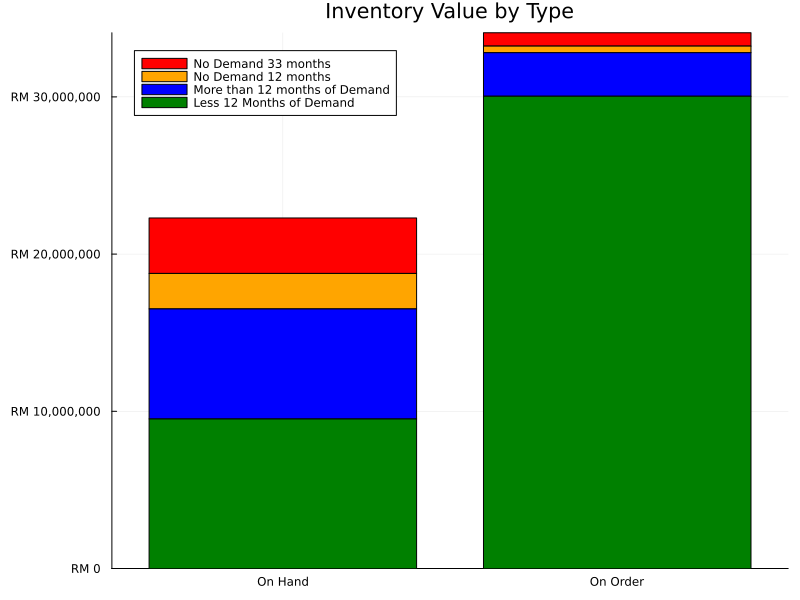

In [38]:
# add value of inventory on hand and on order
transform!(items,[:INV_ONHAND, :VALUE]=>ByRow((i,v) -> i * v) => :INV_ONHAND_VALUE,[:INV_ONORDER, :VALUE]=>ByRow((i,v) -> i * v) => :INV_ONORDER_VALUE)
total_onhand_inventory_value = sum(items[!,:INV_ONHAND_VALUE])
total_onorder_inventory_value = sum(items[!,:INV_ONORDER_VALUE])
@show money(total_onhand_inventory_value)
@show money(total_onorder_inventory_value)
# add total and last 12 demand
sort!(demand, [:ITEM,:MONTH])
remove_columns!(items, [:TOTAL_DEMAND, :LAST_12M_DEMAND])
leftjoin!(items, combine(groupby(demand,:ITEM),:DEMAND=>(x->(TOTAL_DEMAND=sum(x),LAST_12M_DEMAND=sum(x[end-11:end])))=>AsTable), on=:ITEM)
transform!(items, :TOTAL_DEMAND=>(x->coalesce.(x,0))=>:TOTAL_DEMAND,:LAST_12M_DEMAND=>(x->coalesce.(x,0))=>:LAST_12M_DEMAND)
transform!(items, [:LAST_12M_DEMAND,:VALUE]=>ByRow((i,v) -> i * v)=>:LAST_12M_SALES)
# Inventory in Months of Supply, -1 is used when no demand
transform!(items, [:INV_ONHAND,:LAST_12M_DEMAND] => ByRow((i,d) -> d > 0 ? 12i / d : -1) => :OH_MONTHS_OF_SUPPLY)
transform!(items, [:INV_ONORDER,:LAST_12M_DEMAND] => ByRow((i,d) -> d > 0 ? 12i / d : -1) => :OO_MONTHS_OF_SUPPLY)

# copy to analyze inventory
i1 = select(items, :ITEM, :ABC, :OH_MONTHS_OF_SUPPLY, :INV_ONHAND_VALUE, :INV_ONORDER_VALUE, :LAST_12M_SALES, :TOTAL_DEMAND, :LAST_12M_DEMAND)
# additional rows for the inventory older than 12 months, keep only the part over 12 months
i2 = subset(i1, :OH_MONTHS_OF_SUPPLY => ByRow(>(12)))
transform!(i2, [:OH_MONTHS_OF_SUPPLY,:INV_ONHAND_VALUE,:LAST_12M_SALES]=>ByRow((m,v,l)->(m-12,v-l))=>[:OH_MONTHS_OF_SUPPLY,:INV_ONHAND_VALUE])
transform!(i1, 
    [:OH_MONTHS_OF_SUPPLY,:INV_ONHAND_VALUE,:LAST_12M_SALES,:INV_ONORDER_VALUE]=>
    ByRow((m,v,l,o)-> m>12 ? (12,l,0) : (m,v,o))=>
    [:OH_MONTHS_OF_SUPPLY,:INV_ONHAND_VALUE,:INV_ONORDER_VALUE])
# combine the two parts
append!(i1,i2)

# # # mark items with demand status
transform!(i1, 
[:OH_MONTHS_OF_SUPPLY,:TOTAL_DEMAND, :LAST_12M_DEMAND]=>ByRow(
    (m,td,l12)->(td == 0) ? "No Demand 33 months" : 
    (l12 == 0) ? "No Demand 12 months" : 
    (m > 12) ? "More than 12 months of Demand" : "Less 12 Months of Demand")=>:DEMAND_STATUS)
i1[!,:DEMAND_STATUS] = categorical(i1[!,:DEMAND_STATUS], ordered=true)
levels!(i1[!,:DEMAND_STATUS], ["No Demand 33 months", "No Demand 12 months", "More than 12 months of Demand", "Less 12 Months of Demand"])


# aggregate inventories by demand flag and category
difc = combine(groupby(i1, [:ABC,:DEMAND_STATUS]), :INV_ONHAND_VALUE=>sum=>:INV_ONHAND_VALUE,:INV_ONORDER_VALUE=>sum=>:INV_ONORDER_VALUE)
# aggregate all inventory by demand flag
dif = combine(groupby(difc, :DEMAND_STATUS), :INV_ONHAND_VALUE=>sum=>:INV_ONHAND_VALUE,:INV_ONORDER_VALUE=>sum=>:INV_ONORDER_VALUE,:DEMAND_STATUS)
dif = stack(dif, [:INV_ONHAND_VALUE,:INV_ONORDER_VALUE], variable_name=:INVENTORY, value_name=:VALUE)
transform!(dif, :INVENTORY=>ByRow(x-> x == "INV_ONHAND_VALUE" ? "On Hand" : "On Order")=>:TYPE)

stackedbar(dif, :TYPE, :VALUE, :DEMAND_STATUS, yformatter=money, color = [:red :orange :blue :green], title="Inventory Value by Type",size=(800,600))


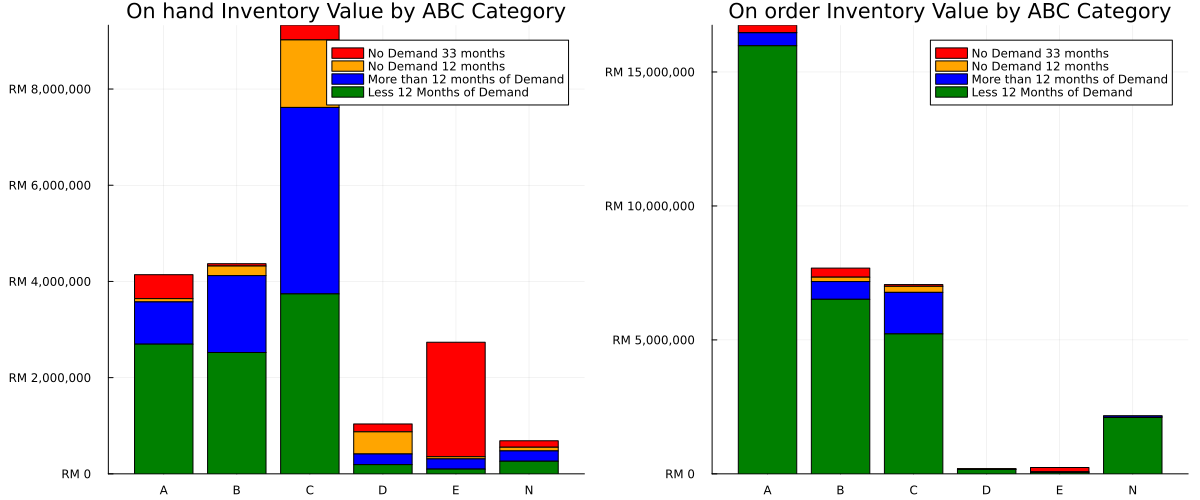

In [39]:
# plot inventory by categories
plot(
stackedbar(difc, :ABC, :INV_ONHAND_VALUE, :DEMAND_STATUS, yformatter=money, color = [:red :orange :blue :green], title="On hand Inventory Value by ABC Category"),
stackedbar(difc, :ABC, :INV_ONORDER_VALUE,:DEMAND_STATUS, yformatter=money, color = [:red :orange :blue :green], title="On order Inventory Value by ABC Category"),
size=(1200,500))

# Top 20 items with no demand since 33 months

In [45]:
# Examples of items with no demand since 33 months, sorted on hand
old = items[items[!,:TOTAL_DEMAND] .== 0,[:ITEM,:DESCRIPTION,:ABC,:INV_ONHAND_VALUE,:INV_ONORDER_VALUE]]
sort!(old, [:INV_ONHAND_VALUE,:INV_ONORDER_VALUE], rev=true)
pretty(old[1:20,:],rename_cols=[:ITEM=>"Item",:DESCRIPTION=>"Description",:ABC=>"ABC",:INV_ONHAND_VALUE=>"On Hand",:INV_ONORDER_VALUE=>"On Order"])

Item,Description,ABC,On Hand,On Order
93310-422X4,BEARING PK 22X28X15.8X2,A,"RM 268,108",RM 0
2PV-WE13E-00,CYLINDER & PISTON RING SET,A,"RM 90,238","RM 215,145"
B6H-E1651-00,"ROD, CONNECTING",E,"RM 71,144",RM 0
5VD-E1310-20,CYLINDER,C,"RM 60,855",RM 0
5LW-11681-00,"PIN, CRANK 1",E,"RM 46,213",RM 0
3XL-F7451-00,footrest 3,A,"RM 38,749",RM 0
1S7-E1681-20,"PIN, CRANK 1 (1S7-E1681-03)",A,"RM 37,182","RM 1,760"
BBW-8591A-20,ENGINE CONTROL UNIT ASSY,E,"RM 28,467",RM 0
3XL-F7461-00,footrest 4,A,"RM 27,601",RM 0
BBW-82590-00,WIRE HARNESS ASSY,E,"RM 26,803",RM 0


In [46]:
# Examples of items with no demand since 33 months, sorted on order
sort!(old, [:INV_ONORDER_VALUE,:INV_ONHAND_VALUE], rev=true)
select!(old, Not([:INV_ONORDER_VALUE,:INV_ONHAND_VALUE]),:INV_ONORDER_VALUE,:INV_ONHAND_VALUE)
pretty(old[1:20,:],rename_cols=[:ITEM=>"Item",:DESCRIPTION=>"Description",:ABC=>"ABC",:INV_ONHAND_VALUE=>"On Hand",:INV_ONORDER_VALUE=>"On Order"])

Item,Description,ABC,On Order,On Hand
2PV-WE13E-00,CYLINDER & PISTON RING SET,A,"RM 215,145","RM 90,238"
2DP-WE13E-00,CYLINDER & PISTON RING SET,B,"RM 215,050",RM 0
55D-H2100-00,BTRY. ASSY. 2 (PTZ5S),E,"RM 105,000",RM 0
33S-E1631-03-B0,"PISTON STD 44P3/2/1,2BR2/1",B,"RM 53,435","RM 7,259"
55K-27412-00,bracket 1,A,"RM 50,400",RM 66
5P0-E1631-11,PISTON (STD)(5P0-E1631-10),B,"RM 34,639","RM 6,700"
93812-14822,"SPROCKET, DRIVE (93822-14824)",E,"RM 16,722","RM 18,664"
1WD-E3907-10,fuel pump comp.,E,"RM 13,204","RM 25,982"
B1X-12121-10,"VALVE, EXHAUST",E,"RM 12,262",RM 230
93306-253Y9,BEARING (1VB),C,"RM 11,828","RM 2,066"


In [54]:
# Examples of items with on hand + on order >12 months
old = select(items,:ITEM,:DESCRIPTION,:ABC,:OH_MONTHS_OF_SUPPLY,:OO_MONTHS_OF_SUPPLY,
    [:OH_MONTHS_OF_SUPPLY,:OO_MONTHS_OF_SUPPLY]=>ByRow((oh,oo)->oh+oo)=>:TOTAL_MONTHS_OF_SUPPLY,
    :INV_ONHAND_VALUE,:INV_ONORDER_VALUE,
    [:INV_ONHAND_VALUE,:INV_ONORDER_VALUE]=>ByRow((h,o)->h+o)=>:TOTAL_INVENTORY_VALUE)
subset!(old,:OH_MONTHS_OF_SUPPLY=>ByRow(>(12)),:INV_ONORDER_VALUE=>ByRow(>(0)))
sort!(old, [:INV_ONORDER_VALUE], rev=true)
pretty(old[1:20,:],rename_cols=[:ITEM=>"Item",:DESCRIPTION=>"Description",:ABC=>"ABC",:OH_MONTHS_OF_SUPPLY=>"On Hand Months",:OO_MONTHS_OF_SUPPLY=>"On Order Months",:TOTAL_MONTHS_OF_SUPPLY=>"Total Months",:INV_ONHAND_VALUE=>"On Hand", :INV_ONORDER_VALUE=>"On Order", :TOTAL_INVENTORY_VALUE=>"Total Value"])

Item,Description,ABC,On Hand Months,On Order Months,Total Months,On Hand,On Order,Total Value
1PA-WE13E-00,CYLINDER & PISTON RING SET,A,19.99,242.62,262.61,"RM 105,824","RM 1,284,247","RM 1,390,072"
5BU-E6150-00,PRIMARY DRIVEN GEAR ASSY,A,22.17,42.60,64.77,"RM 141,637","RM 272,157","RM 413,794"
BBP-E6620-00,CLUTCH CARRIER ASSY,C,14.57,1129.14,1143.71,"RM 3,421","RM 265,061","RM 268,481"
1MA-24500-11,FUEL COCK ASSY 1 (1MA-24500-10,B,19.99,27.08,47.07,"RM 151,952","RM 205,794","RM 357,746"
94568-D6122,CHAIN,C,49.50,7965.00,8014.50,"RM 1,234","RM 198,594","RM 199,828"
2PH-E1311-10,"BODY,CYLINDER 1 B921",A,476.00,14600.00,15076.00,"RM 5,950","RM 182,500","RM 188,450"
BBP-E7670-00,SECONDARY SLIDINGSHEAVE,C,382.29,1905.14,2287.43,"RM 33,771","RM 168,300","RM 202,071"
94568-K8124,CHAIN,C,612.00,24000.00,24612.00,"RM 4,049","RM 158,800","RM 162,849"
1FC-E1310-00,CYLINDER,B,588.00,1320.00,1908.00,"RM 70,410","RM 158,064","RM 228,475"
2DP-E1311-10,"BODY,CYLINDER 1 BG33",C,130.91,2629.09,2760.00,"RM 5,729","RM 115,053","RM 120,782"


## Analysis in months of Sales
Based on the demand of the last 12 months

global_average = 4.220306665149107
with_demand_average = 3.55252654490471


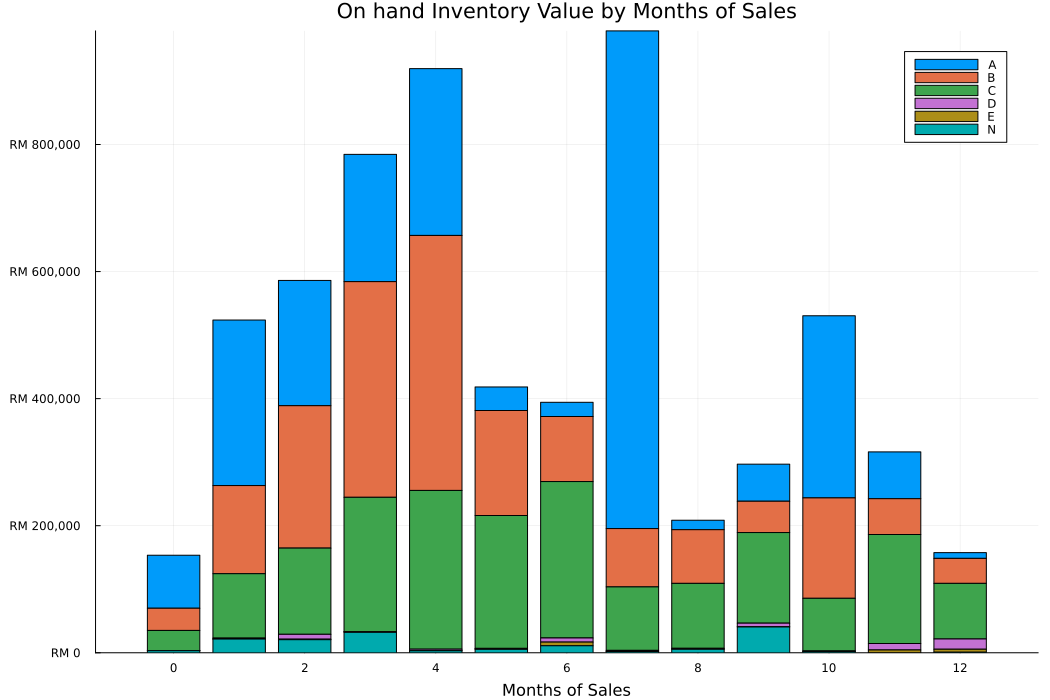

In [76]:
global_average = 12*sum(items[!,:INV_ONHAND_VALUE]) / total_12M_sales
@show global_average

with_demand_average = 12*sum(items[items[!,:TOTAL_DEMAND] .> 0,:INV_ONHAND_VALUE]) / last_12m_sales
@show with_demand_average


# collect for plotting inventory value from by months of supply
mlimit = 12
find_bucket(m) = m <= -1 ? -1 : m > mlimit ? -1 : round(Int,m)
dim = select(items, :OH_MONTHS_OF_SUPPLY => ByRow(find_bucket) => :NB_MONTHS, :ABC, :INV_ONHAND_VALUE)
subset!(dim, :NB_MONTHS =>ByRow(>=(0))) # keepd with demand
dim = combine(groupby(dim, [:NB_MONTHS,:ABC]), :INV_ONHAND_VALUE => sum => :INV_ONHAND_VALUE)

stackedbar(dim,:NB_MONTHS,:INV_ONHAND_VALUE,:ABC,title="On hand Inventory Value by Months of Sales",xlabel="Months of Sales",yformatter=money,size=(1050,700))


average = 6.4501740208378


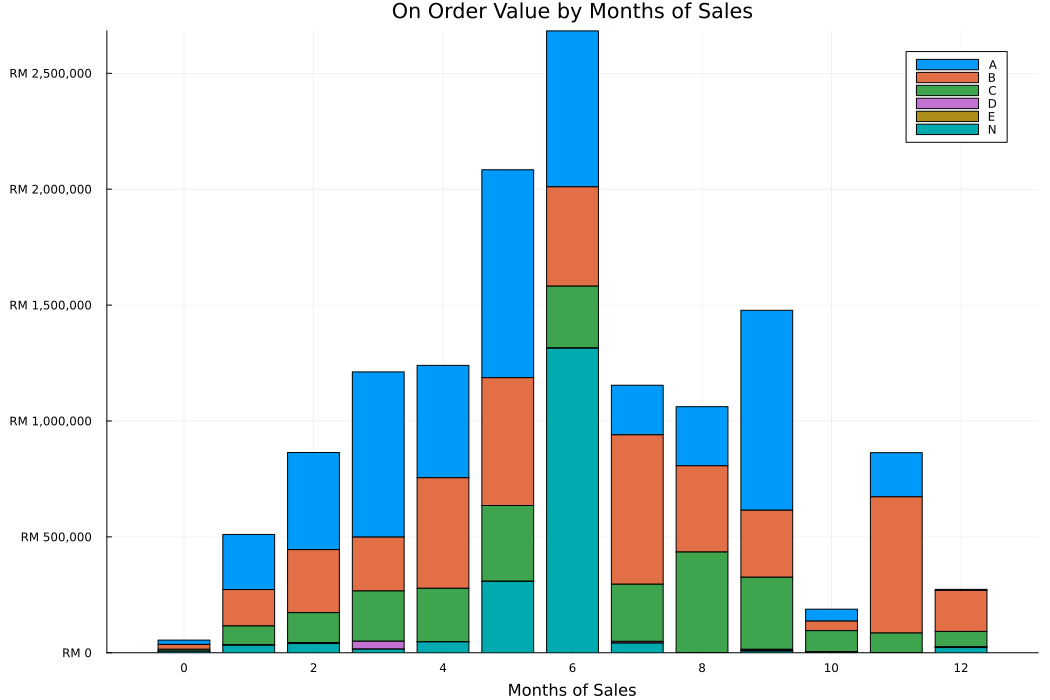

In [77]:

average = 12*sum(items[!,:INV_ONORDER_VALUE]) / total_12M_sales
@show average

# collect for plotting on order value from by months of supply
mlimit = 12
find_bucket(m) = m <= -1 || m > mlimit ? -1 : round(Int,m)
dim = select(items, :OO_MONTHS_OF_SUPPLY => ByRow(find_bucket) => :NB_MONTHS, :ABC, :INV_ONORDER_VALUE)
subset!(dim, :NB_MONTHS =>ByRow(>=(0))) # keepd with demand
dim = combine(groupby(dim, [:NB_MONTHS,:ABC]), :INV_ONORDER_VALUE => sum => :INV_ONORDER_VALUE)


stackedbar(dim,:NB_MONTHS,:INV_ONORDER_VALUE,:ABC,title="On Order Value by Months of Sales",xlabel="Months of Sales",yformatter=money,size=(1050,700))


## Analysis of Service

In [68]:
# first use average demand for the last 12 months
transform!(items, :LAST_12M_DEMAND=>(x->x / 12) => :LAST_MONTH_DEMAND)

# compute unserved demand from on hand and on order inventory
transform!(items, [:INV_ONHAND, :INV_ONORDER, :LAST_MONTH_DEMAND, :OO_MONTHS_OF_SUPPLY] => ByRow((oh, oo, lmd, oom) -> max(0,lmd - oh - oo/max(1,oom))) => :UNSERVED_DEMAND)
# total value of demand and unserved demand for last month
demand_value = value(items, :LAST_MONTH_DEMAND)
unserved_demand_value = value(items, :UNSERVED_DEMAND)
@show money(demand_value)
@show money(unserved_demand_value)
service = 1 - unserved_demand_value/demand_value
@show percentage(service)

money(demand_value) = "RM 5,283,217"
money(unserved_demand_value) = "RM 578,201"
percentage(service) = "89.06%"


"89.06%"

## Analysis of Forecast

In [80]:
#ab = lr.(Ref(demand),propertnames(demand)[2:end])
plot_demand(demand,[14])

BoundsError: BoundsError: attempt to access 507045×3 DataFrame at index [!, 14]

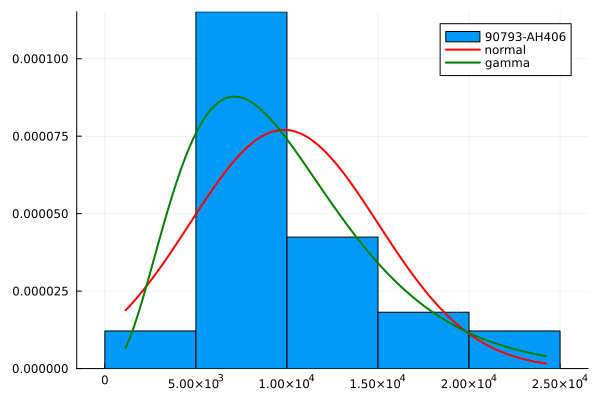

In [74]:
histo_demand(demand,[14],lognormal=false)

money(total_12M_sales) = "RM 63,398,607"


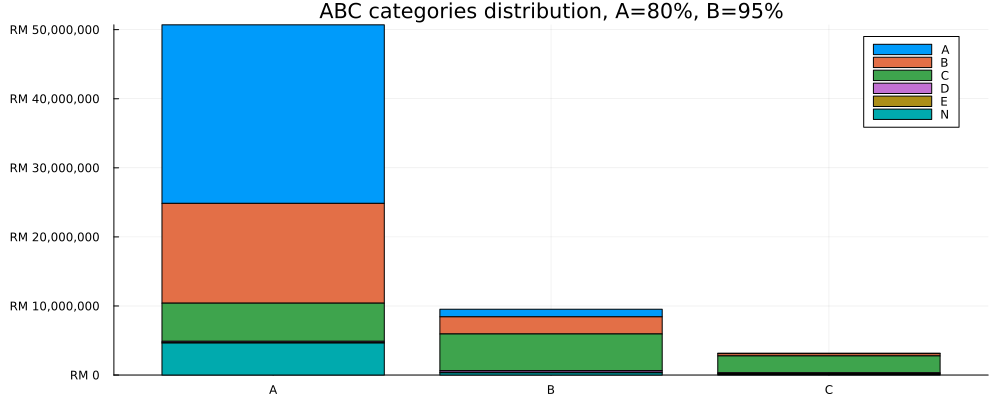

In [9]:


# recompute ABC categories
total_12M_sales = dot(items[!,:LAST_12M_DEMAND],items[!,:VALUE])
@show money(total_12M_sales)
pa = 0.8; pb = 0.95
nabc = subset(items, :LAST_12M_DEMAND => ByRow(>(0))) |>
df->select(df, :ITEM, :ABC, :VALUE, :LAST_12M_DEMAND, [:VALUE, :LAST_12M_DEMAND] => ByRow(*) => :LAST_12M_SALES) |>
df->sort!(df, :LAST_12M_SALES, rev=true) |>
df->transform(df, :LAST_12M_SALES => cumsum => :CUMULATIVE_SALES) |>
df->transform(df, :CUMULATIVE_SALES => ByRow(x->x/total_12M_sales) => :CUMULATIVE_PERCENT) |>
df->transform(df, :CUMULATIVE_PERCENT => ByRow(x-> x<pa ? "A" : x<pb ? "B" : "C") => :NEW_ABC)

nabcg = combine(groupby(nabc, [:NEW_ABC,:ABC]), :LAST_12M_SALES => sum => :LAST_12M_SALES)


# plot the distribution of ABC categories
stackedbar(nabcg, :NEW_ABC, :LAST_12M_SALES, :ABC, yformatter=money, title="ABC categories distribution, A=$(percentage(pa,0)), B=$(percentage(pb,0))",size=(1000,400))
# g = combine(groupby(nabc, [:ABC, :NEW_ABC]), :LAST_12M_SALES => sum => :SALES)
# groupedbar(g[!,:NEW_ABC],g[!,:SALES],group=g[!,:ABC],
# bar_position=:stack,legend=:topright,title="ABC categories distribution, A=$(percentage(pa,0)), B=$(percentage(pb,0))",yformatter=money,size=(1000,400))


argmax(ditems[!, :N_DEMAND]) = 409
argmax(ditems[!, :COEF]) = 725
argmin(ditems[!, :COEF]) = 724
argmax(ditems[!, :CV]) = 7268


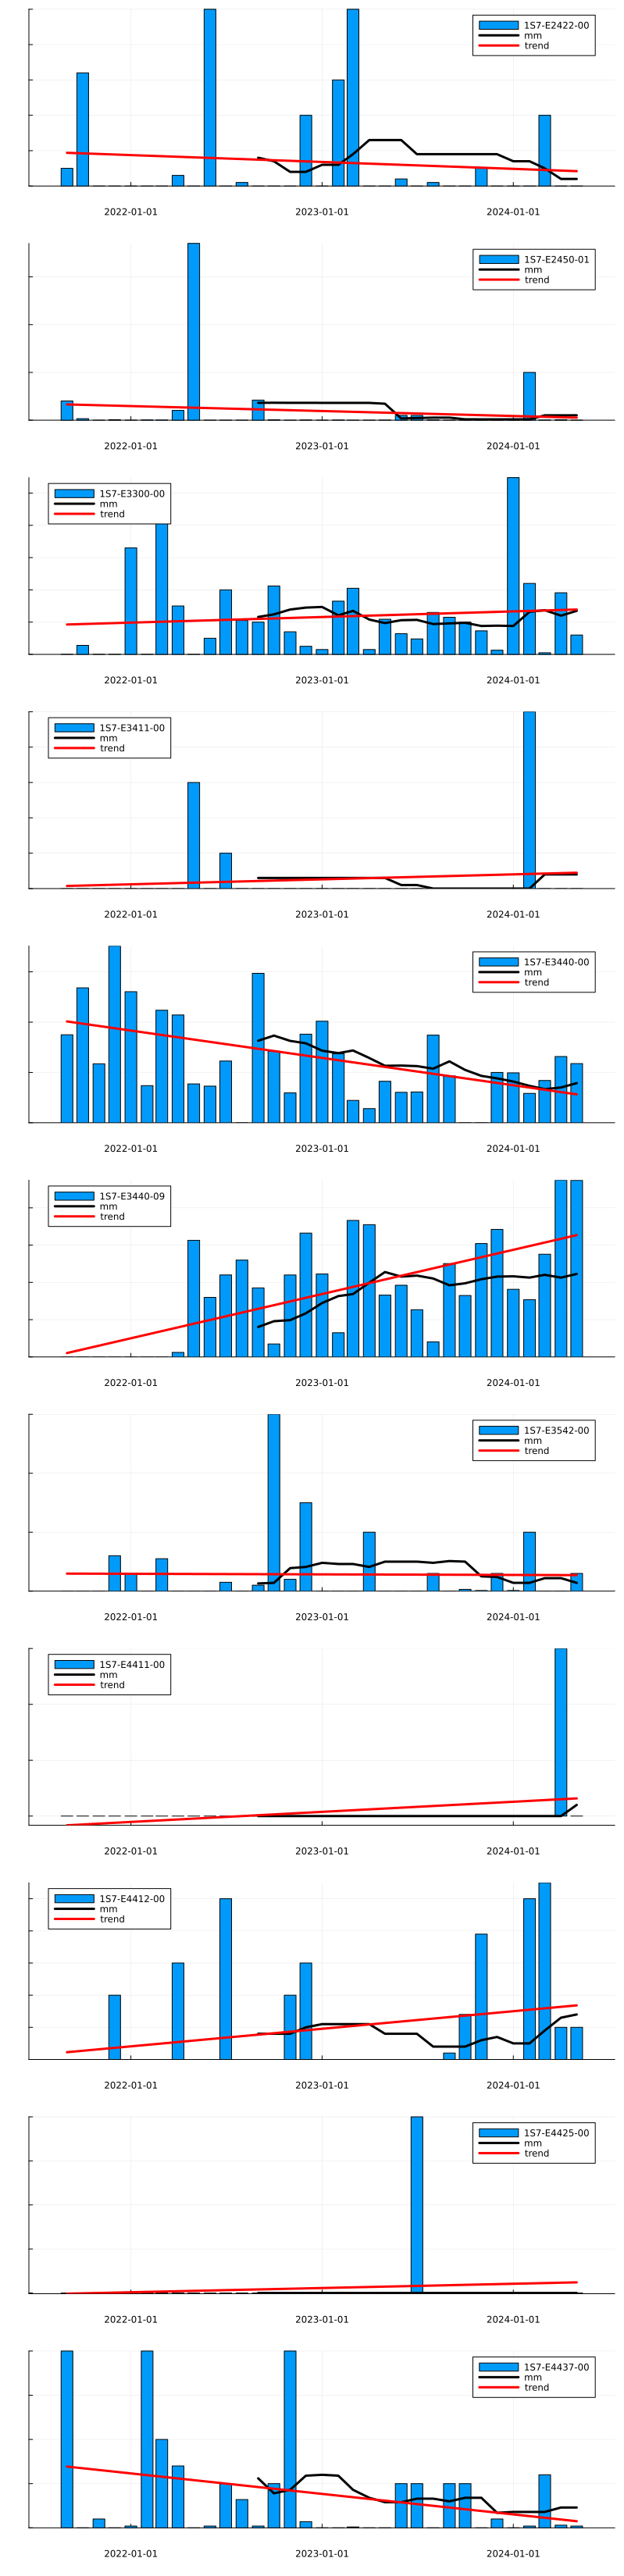

In [168]:
# items demand info - number of demand month, linear regression
ditems = combine(groupby(demand,:ITEM), :DEMAND => (x->count(>(0),x)) => :N_DEMAND, :DEMAND => (x->[lr(x)]) => [:COEF,:INTERCEPT], :DEMAND => (x->mean(x)) => :MEAN_DEMAND, :DEMAND => (x->std(x)) => :STD_DEMAND)
ditems.CV = map(x -> (isnan(x) || x == Inf) ? 0 : x,ditems.STD_DEMAND ./ ditems.MEAN_DEMAND)

@show argmax(ditems[!,:N_DEMAND])
@show argmax(ditems[!,:COEF])
@show argmin(ditems[!,:COEF])
@show argmax(ditems[!,:CV])

#@show ditems[7268,:]
#@show demand[demand[!,:ITEM].== ditems[7268,:ITEM],:DEMAND]

plot_demand(demand,ditems[720:730,:ITEM])
#histo_demand(demand,ditems[8273:8273,:ITEM],normal=false,gamma=false)

### TO DO
- [ ] Forecast Bias & Error
- [ ] Compare different forecasts


